In [1]:
import requests
import mysql.connector
import textdistance
import time
import random
import xmltodict
import urllib, urllib.request
import matplotlib.pyplot as plt
import selenium as se
from collections import Counter
from bs4 import BeautifulSoup
from difflib import SequenceMatcher

import pandas as pd

In [2]:
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                              host='127.0.0.1',
                              database='computervision')
cursor = cnx.cursor()
headers = {"x-api-key": "M7HSjQNeTfai6l7JUiDZB8XYc85BHnHt3R0NXSEd"}
#pg = ProxyGenerator()

# Author as input feature

In [4]:
# Fetch Papers with one author
#cursor.execute("SET SESSION group_concat_max_len=15000;")
cursor.execute("select p.PaperID as PaperID, GROUP_CONCAT(distinct b.AuthoredByID) as authors, count(*) as authorCount,p.Leaf, Avg(a.hIndex) from Papers p, authoredBy b, Authors a where p.PaperID = b.PaperID and b.AuthoredByID != 0 and b.AuthoredByID = a.AuthorID group by p.PaperID, p.Leaf")
temp_table = cursor.fetchall()
temp_table_df = pd.DataFrame(temp_table, columns =['ReferencedByID', 'authors', 'authorCount', "isLeaf", "paperCount"])
temp_table_df2 = pd.DataFrame(temp_table, columns =['ReferenceID', 'authors', 'authorCount', "isLeaf", "paperCount"])
cursor.execute("select * from referencedBy")
temp_table_reference_by = cursor.fetchall()
reference_by_df = pd.DataFrame(temp_table_reference_by, columns =['ReferenceID', 'ReferencedByID'])
referenced_paper = temp_table_df[temp_table_df["isLeaf"] == 0]

In [5]:
all_references = pd.merge(referenced_paper, reference_by_df, on="ReferencedByID")
all_references_w_authors = pd.merge(all_references, temp_table_df2, on="ReferenceID")

In [6]:
final_table = all_references_w_authors.groupby(["ReferencedByID","authors_x", "authorCount_x", "paperCount_x"], as_index = False).agg({'authors_y': ','.join})

In [7]:
# Check for authorCount = 1
#final_table_one_author = final_table.loc[(final_table["paperCount_x"] >= 250) & (final_table["paperCount_x"] > 250)]
#print(len(final_table_one_author))
#final_table_one_author = final_table
#&  & (final_table["paperCount_x"] >= 5) & (final_table["paperCount_x"] < 10)
final_table_one_author = final_table[final_table["authorCount_x"] == 1]
#final_table_one_author = final_table
final_table_one_author

,ReferencedByID,authors_x,authorCount_x,paperCount_x,authors_y
22,00e7632afa5a7f197e47462e3f3cc7ea325500f6,1807477,1,14.0000,"145341374,1895356,33354551,6803671,2423230,144..."
24,010cd20cb3e34afeb21d17fe39c3f171a3621097,48968505,1,0.0000,"1687120,1753210,1782282,2117314646,2983898,304..."
28,0144bd0be143c725977e51b6e9d24ad627cb6b48,144700150,1,2.0000,"2372854,3170090,2027354,2108004595,2151330910,..."
40,01e146bda052577befaa964f1cfe3528ff6b6036,2604889,1,10.0000,"3160228,1695689,1710604,1407546424,1708655,210..."
45,0219af37bd7902472bf8a434046cb4c33eeb31f0,1409093688,1,8.0000,"1737063,1709398,1780112,1746242,12811570,35850..."
...,...,...,...,...,...
5237,fe5098997cfe6c7f40b90dcfcc0308ef74dcf627,3141914,1,9.0000,"1695689,1701686,2064160,143949035,1688882,2060..."
5245,fe94d5929f94a430edba6ec22c0a7e4de83cde2f,1722674,1,25.0000,"143655949,145327322,1829806,3141932,144783015,..."
5249,fed29c0b5c15ed8c57eed218e2702639617351ca,1730952,1,13.0000,"1711460,1687120,1753210,1782282,2117314646,298..."
5256,ff5d09e7b2fb2ac440e2c9a7b8e063efbfce330b,1722674,1,25.0000,"2796589,31641158,2071405842,1722674,1768559,60..."


### Simple Count approach

In [17]:
def author_matches(top_n, cited_list, cur_authors, remove_ties = True):
    most_cited = cited_list[:top_n]
    list_index = most_cited[-1][1]
    most_cited_author_ids = [x[0] for x in most_cited if x[1] == list_index]
    all_cited_with_index = [x[0] for x in cited_list if x[1] == list_index]

    for author in all_cited_with_index:
        if author not in most_cited_author_ids:
            most_cited = filter(lambda x: x[1] != list_index, most_cited)

    for author in cur_authors:
        if author in [author[0] for author in most_cited]:
            return True
    return False

In [9]:
totalCount = 0
totalCorrect = 0
matched = []
for row in final_table_one_author.iterrows():
    most_cited_authors = []
    authors = row[1]["authors_x"].split(",")
    cited_authors = row[1]["authors_y"].split(",")
    all_cited = dict(Counter(cited_authors))
    all_cited_sorted = sorted([(cited, all_cited[cited]) for cited in all_cited], key=lambda x:x[1], reverse=True)
    if author_matches(1, all_cited_sorted, authors):
        totalCorrect += 1
        matched.append(row[1]["ReferencedByID"])
    totalCount += 1
totalCorrect/totalCount

0.17869415807560138


| 1       | 2     | 3     | 4     | max   |
|---------|-------|-------|-------|-------|
| 22      | 27.84 | 31.44 | 33.33 | 56.35 |
| 18.88   | 25.07 | 29.7  | 31.72 | 63.28 |
| 25.57   | 33.19 | 37.08 | 40.33 | 71.93 |
| 26.88   | 35.29 | 39.78 | 43.99 | 78.49 |
|---------|-------|-------|-------|-------|
| 25.24 | 32.57 | 37.03 | 40.06 | 71.29 |

### Remove Ties

| 1         | 2       | 3       | 4       | max   |
|-----------|---------|---------|---------|-------|
| 17.9      | 24.57   | 28.35   | 30.58   | 56.35 |
| 13.36     | 19.02   | 20.75   | 23.06   | 63.28 |
| 18.36     | 22.80   | 25.09   | 25.92   | 71.93 |
| 19.55     | 24.24   | 26.00   | 25.12   | 78.49 |
| --------- | ------- | ------- | ------- |-------|
| 18.25     | 22.60    | 24.34   | 25.52   | 71.29 |

### Weight per paper

| 1         | 2       | 3       | 4       | max   |
|-----------|---------|---------|---------|-------|
| 23.54     | 30.07   | 33.68   | 37.11   | 56.35 |
| 15.75     | 20.37   | 24.18   | 24.93   | 63.28 |
| 16.98     | 22.52   | 26.06   | 29.38   | 71.93 |
| 17.79     | 22.29   | 24.93   | 26.78   | 78.49 |
| --------- | ------- | ------- | ------- |-------|
| 17.96     | 22.84    | 25.90   | 28.05   | 71.29 |

All papers & Top 1 of all authorCounts for average papercount
853 |  882 | 839 | 944 | 667 | 1081

| < 33 | 33-66 | 66-100 | 100-150 | 150-200 | >200   |
|------|-------|--------|---------|---------|--------|
| 5.81 | 14.17  | 16.81  | 20.97   | 25.64   | 24.14  |
| 4.8 | 12.7 | 18.47 | 22.03 | 21.6 | 26.46 |


Papers with 1 author

all papercounts: 23.54
>= 25: 32.47
>= 50: 39.84
>= 100: 44.29
>= 150: 48.86
> Top 10: 50%

Average hIndex

[0.1796429927838967,
 0.21138211382113822,
 0.2370266479663394,
 0.25058823529411767,
 0.26288659793814434]


### Weighted simple count approach

In [215]:
def weighted_simple_count(final_table_one_author):
    totalCount = 0
    totalCorrect = 0
    print(len(final_table_one_author))
    for row in final_table_one_author.iterrows():
        referenced_papers = all_references_w_authors[all_references_w_authors["ReferencedByID"] == row[1]["ReferencedByID"]]
        authors = row[1]["authors_x"].split(",")
        referenced_authors = {}
        for ref in referenced_papers.iterrows():
            ref_authors = ref[1]["authors_y"].split(",")
            weight = 1/len(ref_authors)
            for ref_author in ref_authors:
                if ref_author not in referenced_authors:
                    referenced_authors[ref_author] = 0
                referenced_authors[ref_author] += weight

        all_cited_sorted = sorted([(cited, referenced_authors[cited]) for cited in referenced_authors], key=lambda x:x[1], reverse=True)
        if author_matches(1, all_cited_sorted, authors):
            totalCorrect += 1
        totalCount += 1
    if totalCount == 0:
        return 0
    return totalCorrect/totalCount

In [231]:
weighted_simple_count(final_table_one_author[-10:])

10


0.5

In [172]:
def hIndex_accuracies(buckets, max_value, final_table_temp):
    start_value = 0
    accuracies = []
    break_out = False
    while not break_out:
        bucket_value = start_value + buckets
        if start_value >= max_value:
            bucket_value = 100000
            break_out = True
        filtered_table = final_table_temp.loc[(final_table_temp["paperCount_x"] >= start_value)]
        print(len(filtered_table))
        accuracies.append(weighted_simple_count(filtered_table))
        start_value += buckets
    return accuracies

In [176]:
hIndex_accuracies(10, 40, final_table)

5266
4182
2852
1700
970


[0.1796429927838967,
 0.21138211382113822,
 0.2370266479663394,
 0.25058823529411767,
 0.26288659793814434]

# Affiliation

In [9]:
cursor.execute("select p.PaperID, count(*) as authorCount from authoredBy a, Papers p where p.PaperID = a.PaperID and p.Leaf = 0 and a.AuthoredByID != 0 group by p.PaperID")
authorCount = cursor.fetchall()
temp_authorCount_table_df = pd.DataFrame(authorCount, columns=["PaperID_y", "authorCount"])

In [11]:
cursor.execute("select p.PaperID, group_concat(t.affiliatedTo) from Authors a, affiliatedTo t, Papers p, authoredBy b where p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID and a.AuthorID = t.AuthorID and t.affiliatedTo != 1 group by p.PaperID")
grouped_affiliations = cursor.fetchall()
cursor.execute("select * from referencedBy")
references = cursor.fetchall()
temp_ref_table_df = pd.DataFrame(references, columns=["reference_id", "referenced_by_id"])
temp_aff_table_df = pd.DataFrame(grouped_affiliations, columns =['PaperID', 'affiliations'])

In [12]:
temp1 = pd.merge(temp_ref_table_df, temp_aff_table_df, how="inner",left_on="referenced_by_id", right_on="PaperID")
temp1 = pd.merge(temp_aff_table_df, temp1, how="inner", left_on="PaperID", right_on="reference_id")
temp1 = pd.merge(temp_authorCount_table_df, temp1, how="inner", on="PaperID_y")
final_table = temp1.groupby(["PaperID_y","affiliations_y", "authorCount"], as_index = False).agg({'affiliations_x': ','.join})
final_table_filtered = final_table

In [336]:
total_count = 0
correct_count = 0
for row in final_table_filtered.iterrows():
    target_affiliations = row[1]["affiliations_y"].split(",")
    input_affiliations = row[1]["affiliations_x"].split(",")
    all_cited_affiliations = dict(Counter(input_affiliations))
    sorted_affiliations = sorted(all_cited_affiliations.items(), key=lambda x: x[1], reverse=True)
    if author_matches(4, sorted_affiliations, target_affiliations):
        correct_count += 1
    total_count += 1
correct_count/total_count

0.41933445661331087

In [371]:
# Weighted affiliations
total_count = 0
correct_count = 0
for row in final_table_filtered.iterrows():
    target_affiliations = row[1]["affiliations_y"].split(",")
    referenced_affiliations = temp1[temp1["referenced_by_id"] == row[1]["PaperID_y"]]
    all_cited_affiliations = {}
    for ref in referenced_affiliations.iterrows():
        ref_affiliations = ref[1]["affiliations_x"].split(",")
        weight = 1/len(ref_affiliations)
        for ref_author in ref_affiliations:
            if ref_author not in all_cited_affiliations:
                all_cited_affiliations[ref_author] = 0
            all_cited_affiliations[ref_author] += weight
    sorted_affiliations = sorted(all_cited_affiliations.items(), key=lambda x: x[1], reverse=True)
    if author_matches(40000, sorted_affiliations, target_affiliations):
        correct_count += 1
    total_count += 1
correct_count/total_count

0.8159224936815501

# Solution

Remove Ties no weights:

| 1         | 2       | 3       | 4       | max     |
|-----------|---------|---------|---------|---------|
| 19.18     | 31.2    | 37.34   | 44.50   | 76.47   |
| 19.10     | 27.74   | 32.84   | 36.90   | 76.75   |
| 25.50     | 38.88   | 38.29   | 41.26   | 80.74   |
| 25.50     | 35.10   | 39.10   | 41.00   | 83.50   |
| --------- | ------- | ------- | ------- | ------- |
| 25.93     | 34.81   | 38.92   | 41.93   | 81.59   |

Including weights:

| 1         | 2       | 3       | 4      | max     |
|-----------|---------|---------|--------|---------|
| 31.97     | 42.46   | 48.59   | 52.69  | 76.47   |
| 23.77     | 33.54   | 40.54   | 44.08  | 76.75   |
| 28.85     | 33.09   | 43.49   | 46.91  | 80.74   |
| 26.30     | 37.10   | 45.90   | 49.00  | 83.50   |
| --------- | ------- | ------- | ------ | ------- |
| 29.00     | 39.44   | 46.08   | 49.01  | 81.59   |


# Country

In [6]:
cursor.execute("select p.PaperID, group_concat(af.Country) from Authors a, affiliatedTo t, Papers p, authoredBy b, Affiliations af where p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID and a.AuthorID = t.AuthorID and t.affiliatedTo = af.AffiliationID and af.Country is not NULL group by p.PaperID")
grouped_affiliations = cursor.fetchall()
cursor.execute("select * from referencedBy")
references = cursor.fetchall()
temp_ref_table_df = pd.DataFrame(references, columns=["reference_id", "referenced_by_id"])
temp_aff_table_df = pd.DataFrame(grouped_affiliations, columns =['PaperID', 'country'])

In [14]:
temp1 = pd.merge(temp_ref_table_df, temp_aff_table_df, how="inner",left_on="referenced_by_id", right_on="PaperID")
temp1 = pd.merge(temp_aff_table_df, temp1, how="inner", left_on="PaperID", right_on="reference_id")
temp1 = pd.merge(temp_authorCount_table_df, temp1, how="inner", on="PaperID_y")
final_table = temp1.groupby(["PaperID_y","country_y", "authorCount"], as_index = False).agg({'country_x': ','.join})
final_table = final_table

In [18]:
# weighted countries
total_count = 0
correct_count = 0
for row in final_table.iterrows():
    target_country = row[1]["country_y"].split(",")
    input_country = row[1]["country_x"].split(",")
    all_cited_countries = dict(Counter(input_country))
    sorted_countries = sorted(all_cited_countries.items(), key=lambda x: x[1], reverse=True)
    if author_matches(1, sorted_countries, target_country):
        correct_count += 1
    total_count += 1
correct_count/total_count

0.4782334384858044

In [19]:
total_count = 0
correct_count = 0
for row in final_table.iterrows():
    target_country = row[1]["country_y"].split(",")
    referenced_countries = temp1[temp1["referenced_by_id"] == row[1]["PaperID_y"]]
    all_cited_countries = {}
    for ref in referenced_countries.iterrows():
        ref_countries = ref[1]["country_x"].split(",")
        weight = 1/len(ref_countries)
        for ref_country in ref_countries:
            if ref_country not in all_cited_countries:
                all_cited_countries[ref_country] = 0
            all_cited_countries[ref_country] += weight
    sorted_countries = sorted(all_cited_countries.items(), key=lambda x: x[1], reverse=True)
    if author_matches(1, sorted_countries, target_country):
        correct_count += 1
    total_count += 1
correct_count/total_count

0.44647739221871713

# Solution

Remove Ties no weights:

| 1         | 2       | 3       | 4      | max     |
|-----------|---------|---------|--------|---------|
| 29.77     | 47.33   | 58.52   | 69.21  | 89.82   |
| 39.26     | 55.82   | 63.59   | 68.51  | 89.13   |
| 46.54     | 64.83   | 71.60   | 75.84  | 92.86   |
| 52.75     | 69.73   | 75.12   | 79.12  | 95.00   |
| --------- | ------- | ------- | ------ | ------- |
| 47.82     | 64.98   | 71.40   | 76.28  | 92.91   |

Remove Ties with weights:

| 1         | 2       | 3       | 4      | max     |
|-----------|---------|---------|--------|---------|
| 29.77     | 47.33   | 58.52   | 69.21  | 89.82   |
| 39.26     | 55.82   | 63.59   | 68.51  | 89.13   |
| 46.54     | 64.83   | 71.60   | 75.84  | 92.86   |
| 52.75     | 69.73   | 75.12   | 79.12  | 95.00   |
| --------- | ------- | ------- | ------ | ------- |
| 47.82     | 64.98   | 71.40   | 76.28  | 92.91   |

# Gender

In [63]:
cursor.execute("select p.PaperID, group_concat(a.Gender) from Papers p, authoredBy b, Authors a where p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID and a.Gender is not null group by p.PaperID")
grouped_gender = cursor.fetchall()
temp_gender_table_df = pd.DataFrame(grouped_gender, columns =['PaperID', 'gender'])
temp1 = pd.merge(temp_ref_table_df, temp_gender_table_df, how="inner",left_on="referenced_by_id", right_on="PaperID")
temp1 = pd.merge(temp_gender_table_df, temp1, how="inner", left_on="PaperID", right_on="reference_id")
temp1 = pd.merge(temp_authorCount_table_df, temp1, how="inner", on="PaperID_y")
final_table = temp1.groupby(["PaperID_y","gender_y", "authorCount"], as_index = False).agg({'gender_x': ','.join})
final_table = final_table[final_table["authorCount"] == 2]
final_table

,PaperID_y,gender_y,authorCount,gender_x
1,00202f23535fcef5043ec854e18cf0bd5334ced2,"0,0",2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
2,0024437badc418b788a7c3459441bb811eab7670,"1,0",2,"0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,..."
5,0049f82713993ba0da269a8160c8b825299ba397,"1,0",2,"0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0"
17,00ce3ccd8062f3191986ad1a4e9099a784a39a5f,"0,0",2,"0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,..."
20,00e030562704fe34c82c871148864e6092fde0f9,"1,0",2,"0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,..."
...,...,...,...,...
5250,ff0b456110a7c2612fcb71860fac8efcb9dd0dbb,"0,0",2,"0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,..."
5254,ff748e293e9d37aa5399465ba34032038dfc608e,"0,1",2,"0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,..."
5256,ff8900a0ea63210a08ad3bd698e3974e1021d03d,"0,0",2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
5258,ffa8b7851070676f10e7904f02d47ead448da46d,"0,0",2,"0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,..."


In [74]:
male_dist = []
female_dist = []
for row in final_table.iterrows():

    input_gender = row[1]["gender_x"].split(",")
    distribution_females = input_gender.count("1")/len(input_gender)
    #print(distribution_females)
    if row[1]["gender_y"] == "1,0" or row[1]["gender_y"] == "0,1":
        female_dist.append(distribution_females)
    elif row[1]["gender_y"] == "0,0":
        male_dist.append(distribution_females)

In [75]:
print(sum(male_dist)/len(male_dist))
print(sum(female_dist)/len(female_dist))
print((sum(female_dist)+sum(male_dist))/(len(female_dist)+len(male_dist)))

0.12824405793494628
0.15758076567148993
0.13634902416470795


In [61]:
correct = 0
total = 0
for row in final_table.iterrows():
    input_gender = row[1]["gender_x"].split(",")
    distribution_females = input_gender.count("1")/len(input_gender)
    if distribution_females > 0.9:
        if row[1]["gender_y"] == "1":
            correct += 1
    else:
        if row[1]["gender_y"] == "0":
            correct += 1
    total += 1
correct/total

0.8844827586206897

Single female authors tend to cite other females with 25% whereas males have a lower female distribution by 14 %
But how does the distribution for multiple authors look like?

In [476]:
female_distribution = pd.DataFrame(columns=["author_distr", "ref_distr"])
for row in final_table.iterrows():
    target_gender = row[1]["gender_y"].split(",")
    target_females = target_gender.count("1")/len(target_gender)
    feature_gender = row[1]["gender_x"].split(",")
    feature_females = feature_gender.count("1")/len(feature_gender)
    female_distribution.loc[len(female_distribution)] = [target_females,feature_females]

female_distribution = female_distribution.groupby(["author_distr"], as_index = False).mean("ref_distr").sort_values("author_distr")
author_dist = female_distribution["author_distr"].to_numpy()
ref_dist = female_distribution["ref_distr"].to_numpy()

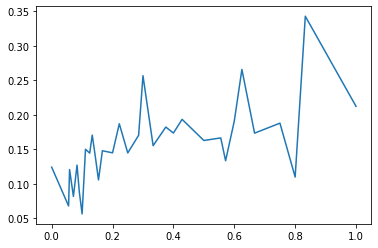

In [478]:
plt.plot(author_dist, ref_dist)
plt.show()